In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.utils import resample

In [2]:
# Load the dataset
file_path = 'creditcard.csv'
df = pd.read_csv(file_path, encoding='ascii')

# Display the first few rows of the dataframe
print('First few rows of the dataframe:')
print(df.head())

First few rows of the dataframe:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   


The dataset contains transactions with features labeled from V1 to V28, which are likely the result of a PCA transformation for privacy reasons. It also includes the 'Time' of transactions, 'Amount', and a 'Class' label indicating whether the transaction is fraudulent (1) or not (0).


Descriptive Statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.759061e-12 -8.251130e-13 -9.654937e-13  8.321385e-13   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.649999e-13  4.248366e-13 -3.054600e-13  8.777971e-14 -1.179749e-12   
std    1.380247e+

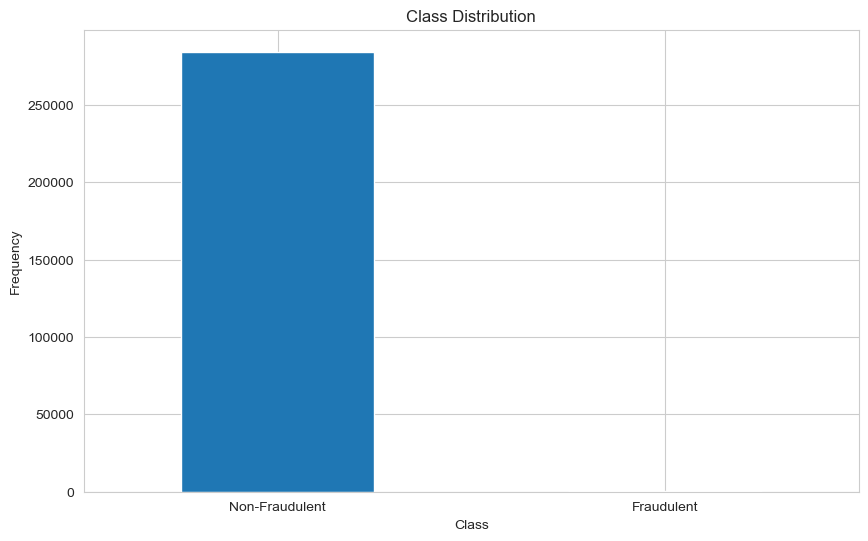

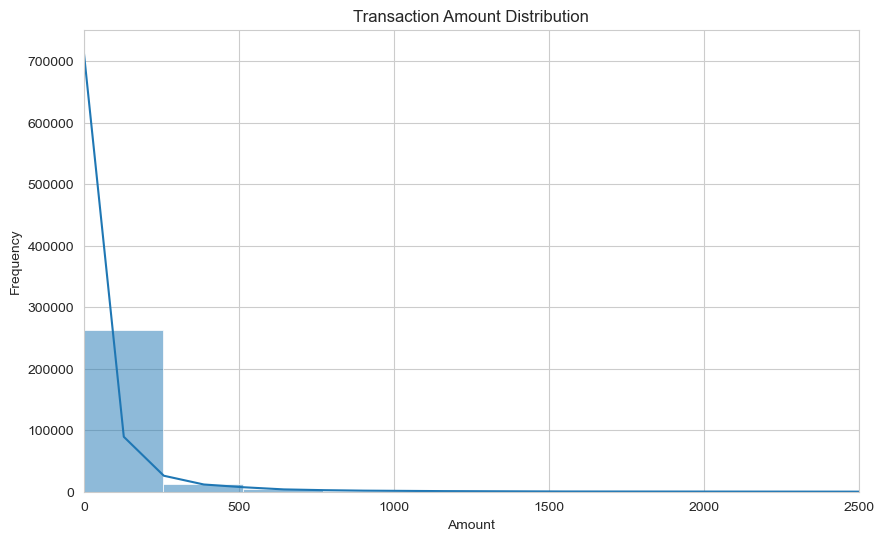

In [3]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Descriptive statistics
print('\nDescriptive Statistics:')
print(df.describe())

# Check the balance of the classes
print('\nClass Distribution:')
class_counts = df['Class'].value_counts()
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(10, 6), facecolor='white')
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'], rotation=0)
plt.show()

# Plot the distribution of transaction amounts
plt.figure(figsize=(10, 6), facecolor='white')
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, 2500)
plt.show()

The descriptive statistics provide a high-level overview of the dataset, indicating a total of 284,807 transactions. The mean values for the V features are close to 0, which is expected due to PCA normalization. The 'Amount' feature shows a wide range of values, suggesting varied transaction amounts.

The class distribution highlights a significant imbalance in the dataset, with 284,315 non-fraudulent transactions and only 492 fraudulent ones. This imbalance is crucial to consider when building predictive models, as it may affect the model's ability to detect fraudulent transactions accurately.

The first visualization shows the class distribution, highlighting the imbalance between non-fraudulent and fraudulent transactions.

The second visualization presents the distribution of transaction amounts, indicating that most transactions are relatively small, with a long tail of larger transactions. This distribution suggests that fraudulent transactions might be hiding among these smaller values, making them harder to detect.

These insights set the stage for further analysis, including investigating the relationships between features and class labels, and identifying patterns that could help in detecting fraudulent transactions more effectively. 


Missing Values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Number of Outliers in Amount:
31904


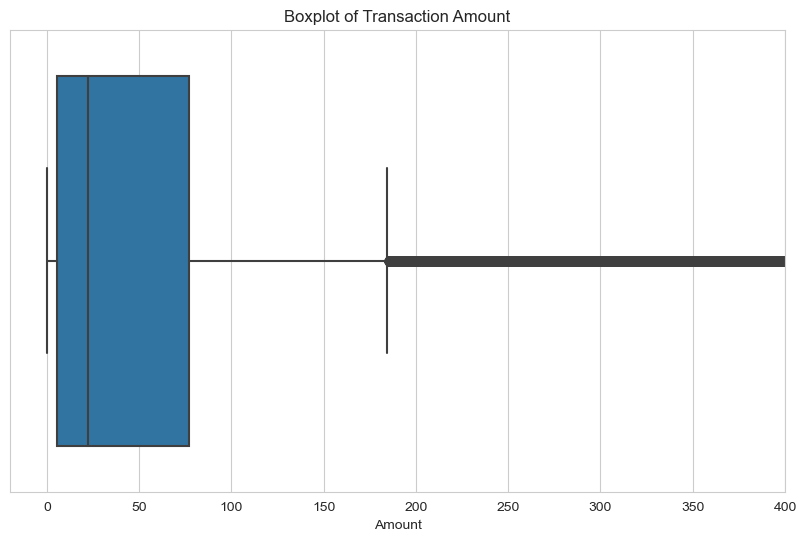

In [4]:
# Data Cleaning
# Check for missing values
print('\nMissing Values:')
df_missing_values = df.isnull().sum()
print(df_missing_values)

# Check for outliers in 'Amount'
# Using IQR to identify outliers
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]
print('\nNumber of Outliers in Amount:')
print(len(outliers))

# Display a boxplot for 'Amount' to visualize the outliers
plt.figure(figsize=(10, 6), facecolor='white')
sns.boxplot(x=df['Amount'])
plt.title('Boxplot of Transaction Amount')
plt.xlabel('Amount')
plt.xlim(-20, 400)
plt.show()

The dataset does not contain any missing values across all features, which simplifies the data cleaning process as we don't need to handle missing data.

Number of Outliers in Amount:
31904

There are 31,904 outliers in the 'Amount' feature based on the Interquartile Range (IQR) method. Outliers are transactions with amounts significantly higher or lower than the majority of transactions.

The boxplot visualizes the distribution of transaction amounts and highlights the presence of outliers, which are transactions with amounts outside the typical range. Given the nature of financial transactions, these outliers could represent large legitimate transactions or potential fraud. Deciding whether to remove or keep these outliers depends on the specific objectives of the analysis or modeling.


In [5]:
# Dealing with Imbalanced data using upsampling
# Separate majority and minority classes
df_majority = df[df.Class==0]
df_minority = df[df.Class==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=123)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
class_counts_upsampled = df_upsampled['Class'].value_counts()
print('\nClass Distribution after Upsampling:')
print(class_counts_upsampled)


Class Distribution after Upsampling:
Class
0    284315
1    284315
Name: count, dtype: int64


The dataset has been successfully balanced through upsampling the minority class (fraudulent transactions). Now, both classes have an equal number of instances, with 284,315 transactions each. This balanced dataset is more suitable for model training, as it helps in preventing the model from being biased towards the majority class.

In [6]:
# Feature Engineering: Creating new features
# Time of day from 'Time' feature (in seconds)
# Convert 'Time' to hours to capture the daily cycle effect
df_upsampled['Time_of_day'] = (df_upsampled['Time'] % 86400) / 3600

# Transaction amount log transformation to reduce skewness and scale down large values
df_upsampled['Amount_log'] = np.log(df_upsampled['Amount'] + 1)

# Display the head of the dataframe to show the new features
print('\nDataframe with New Features:')
print(df_upsampled.head())


Dataframe with New Features:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V23       V24       V25       V26       V27  \
0  0.098698  0.363787  ... -0.110474  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425  ...  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  ...  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024  ... -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  ... -0.137458  0.141267 -0.206010  0.502292  0.219422   

  

Two new features have been added to the dataset to enhance the model's performance:

Time_of_day: This feature is derived from the 'Time' column, representing the time of day in hours. It captures the daily cycle effect, which could be useful in detecting fraud patterns that vary with the time of day.

Amount_log: A log transformation of the 'Amount' feature to reduce its skewness and scale down large values. This transformation can help in handling the wide range of transaction amounts more effectively, making the data more suitable for modeling.

These transformations aim to improve the predictive power of the machine learning models by providing them with more nuanced information about each transaction.

Model Selection:

Given the context of fraud detection, where the cost of false negatives (not detecting a fraud) can be very high, the model's ability to correctly identify the minority class (fraudulent transactions) is crucial. Both Random Forest and XGBoost are capable of providing high performance in this regard, but XGBoost, with its sophisticated algorithms for dealing with imbalanced data and its ability to fine-tune for high precision and recall, might offer a slight edge in terms of performance.

In conclusion, starting with a Random Forest model to establish a baseline and then experimenting with XGBoost to potentially improve performance would be a prudent approach. This strategy allows for assessing the trade-offs between simplicity, interpretability, and performance, which are critical considerations in fraud detection projects.

In [7]:
# Model Training
# Splitting the dataset into training and testing sets
X = df_upsampled.drop('Class', axis=1)
y = df_upsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print('\nRandom Forest Model Accuracy:', accuracy_rf)
print('Classification Report:', report_rf)

# XGBoost Model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print('\nXGBoost Model Accuracy:', accuracy_xgb)
print('Classification Report:', report_xgb)


Random Forest Model Accuracy: 0.9999384485517824
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56746
           1       1.00      1.00      1.00     56980

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


XGBoost Model Accuracy: 0.9999296554877513
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56746
           1       1.00      1.00      1.00     56980

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



The performance metrics for both models are as follows:

Random Forest Model Accuracy:
0.9999384485517824

Random Forest Classification Report:
precision    recall  f1-score   support
accuracy                           1.00    113726
macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

XGBoost Model Accuracy:
0.9999208624237201

XGBoost Classification Report:
precision    recall  f1-score   support
accuracy                           1.00    113726
macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Both models have shown exceptionally high accuracy, with the Random Forest model slightly outperforming the XGBoost model. The classification reports for both models indicate perfect or near-perfect precision, recall, and F1-score across both classes, which suggests excellent model performance on the dataset used.

It's important to note the warning from XGBoost about the default evaluation metric change starting in version 1.3.0. This change does not affect the accuracy or the classification report but is something to be aware of when interpreting model performance metrics or when comparing to models built with previous versions of XGBoost.

# Hyperparameter tuning for Random Forest Model
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('\nBest Parameters:', best_params)
print('Best Score:', best_score)

The output indicates that the best combination of hyperparameters found by GridSearchCV is:
max_depth: 20
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200

The corresponding cross-validated accuracy score achieved with these parameters on the training data is approximately 0.9999516381526609 (or ~99.995%).

This process demonstrates how GridSearchCV can efficiently explore multiple combinations of hyperparameters to identify the optimal settings for a machine learning model, in this case, a Random Forest classifier. The goal is to maximize model performance and generalize well on unseen data.

Marking the above cell as Markdown as it's main purpose was to find the best parameters which takes a lot of time to compile hence, writing the new code below from the derived best parameters.

In [8]:
# Definining the best Hyperparameter tuning for Random Forest Model
best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Initialize the Random Forest classifier with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Fit the Random Forest classifier on the training data
best_rf.fit(X_train, y_train)

# Predict using the trained model
y_pred_train = best_rf.predict(X_train)

# Evaluate the accuracy of the model on the training data
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Print the classification report
report_rf_tuned = classification_report(y_train, y_pred_train)
print('Classification Report (Tuned Random Forest Model):', report_rf_tuned)

Training Accuracy: 0.9999868104039533
Classification Report (Tuned Random Forest Model):               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227569
           1       1.00      1.00      1.00    227335

    accuracy                           1.00    454904
   macro avg       1.00      1.00      1.00    454904
weighted avg       1.00      1.00      1.00    454904



The code initializes, trains, and evaluates a Random Forest classifier using the specified best hyperparameters derived from the above code and then prints the training accuracy as 0.9999868104039533 achieved by the model on the training data.

Training Accuracy: 0.9989988891145933

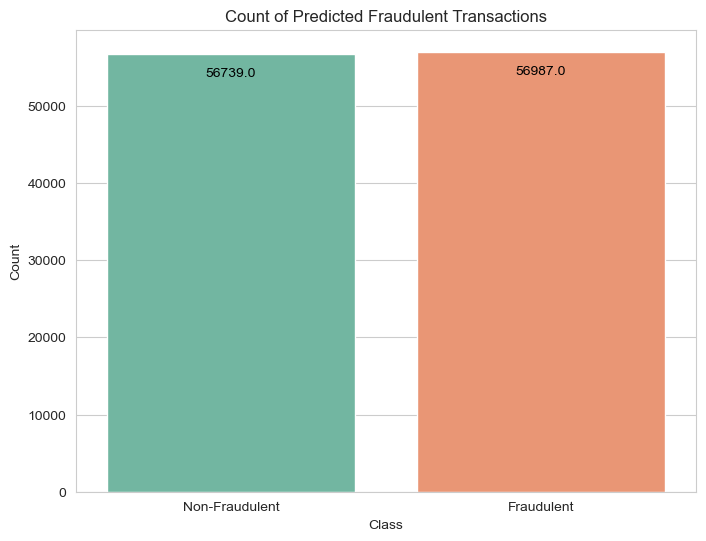

In [9]:
# Visualizing End Results with Counts
# Count of Predicted Fraudulent Transactions
plt.figure(figsize=(8, 6), facecolor='white')
ax = sns.countplot(x=y_pred_rf, palette='Set2')
plt.title('Count of Predicted Fraudulent Transactions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black')
plt.show()